<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.982 · TFM Àrea 5</p>
<p style="margin: 0; text-align:right;">2025/26 Màster Universitari en Ciència de Dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-bottom: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Gestió proactiva de la demanda en Atenció Precoç - Models de predicció de sèries temporals(ARIMA i SARIMA)



En aquesta secció s'exploren dos models estadístics clàssics de predicció de sèries temporals:
- ARIMA (Autoregressive Integrated Moving Average): Un model d'autoregressió de valors temporals, utilitzant la diferenciació per assolir estacionarietat juntament amb un terme de mitjana mòbil per capturar la dependència temporal dels errors.
- SARIMA (Seasonal ARIMA): Extensió del model anterior incorporant el component d'estacionalitat, adequat per a sèries temporals amb patrons periòdics, com ara variacions mensuals o anuals.

Abans d'aplicar altres models més complexos, s'avalua la capacitat predictiva d'aquests dos.

In [3]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.set_context("notebook") 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
with open('../dades/df_cdiap_raw_2020_25.pkl', 'rb') as f:
    data_cdiap = pickle.load(f)

Per l'aplicació dels models es requereix una sèrie temporal univariant. 
La demanda per l'elaboració dels primers models tindrà una granularitat mensual.

In [6]:
ts_demanda_cdiap =(
    data_cdiap
    .groupby("Mes de demanda")
    .size()
)

ts_demanda_cdiap.index = ts_demanda_cdiap.index.to_timestamp()

ts_demanda_cdiap.head()

Mes de demanda
2020-01-01    36
2020-02-01    41
2020-03-01    17
2020-04-01     3
2020-05-01     6
Freq: MS, dtype: int64

Es recorda la forma de la sèrie temporal que es va veure en la primera secció de preprocessament i anàlisi:

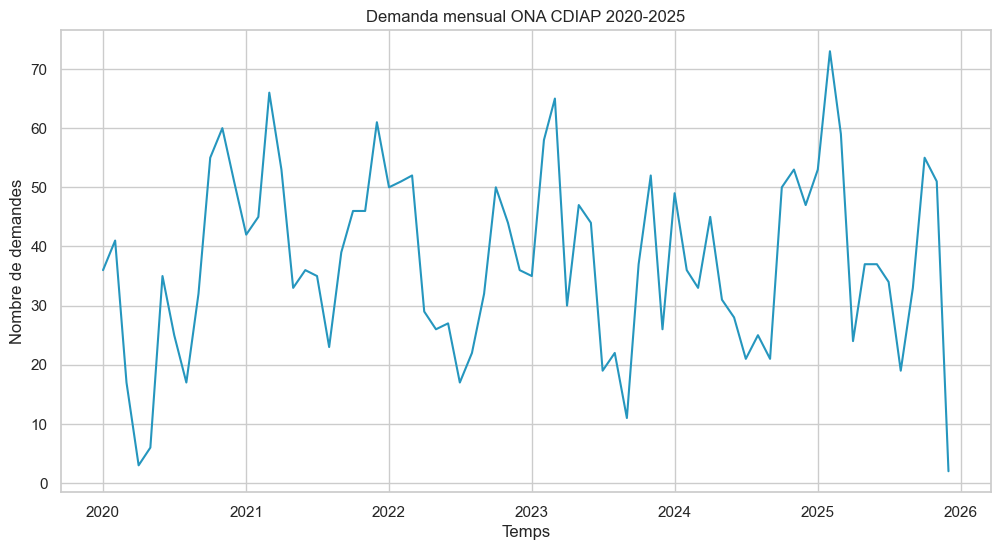

In [8]:
plt.figure(figsize=(12,6))
plt.plot(ts_demanda_cdiap, color="#2596be")
plt.title("Demanda mensual ONA CDIAP 2020-2025")
plt.xlabel("Temps")
plt.ylabel("Nombre de demandes")
plt.show()

A més de fenòmens puntuals com l'impacte de la COVID-19, s'observen patrons estacionals clars en la demanda. Un increment destacable es veu a l'inici del curs escolar, així com una dràstica disminució durant els mesos d'estius. 

Aquest comportament demostra que la sèrie temporal és d'<b>estacionalitat anual<b>.

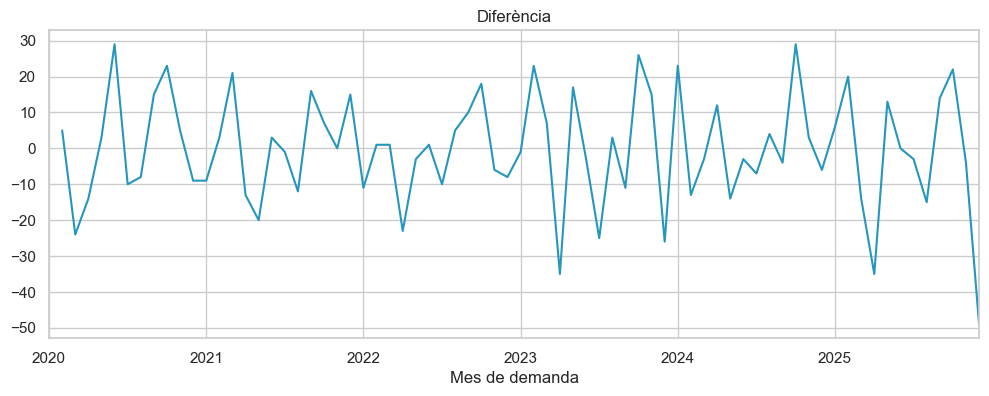

In [10]:
# Grafiquem la diferenciació.
ts_demanda_cdiap.diff().plot(figsize=(12,4), title="Diferència", color="#2596be")
plt.show()

A l'observació de la diferenciació d'ordre 1 s'elimina part de la tendència de la sèrie, igualment mostrant una forta variabilitat. És indicador que, tot i assolir una estacionarietat en mitjana, la sèrie té fluctuacions importants.

## 1. Creació del model ARIMA

Es construeix un primer model ARIMA senzill per establir una referència inicial.

La configuració utilitzada és la següent:
- Component autoregressiu (AR): ordre 1 
- Diferenciació (I): ordre 1  
- Component de mitjana mòbil (MA): ordre 1

In [14]:
model_ARIMA = ARIMA(ts_demanda_cdiap, order=(1,1,1))
model_fit_ARIMA = model_ARIMA.fit()

model_fit_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -288.145
Date:                Sun, 21 Dec 2025   AIC                            582.290
Time:                        20:44:11   BIC                            589.078
Sample:                    01-01-2020   HQIC                           584.989
                         - 12-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4923      0.170      2.894      0.004       0.159       0.826
ma.L1         -0.9992      5.003     -0.200      0.842     -10.806       8.807
sigma2       187.5614    937.057      0.200      0.841   -1649.037    2024.159
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.55   Prob(JB):                         0.57
Heteroskedasticity (H):               1.37   Skew:                            -0.30
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Els resultats del model ARIMA inicial mostren certa dependència temporal captada pel terme autoregressiu (ar.L1), que és estadísticament significatiu (p < 0.01). El terme de mitjana mòbil, per contra, no és significatiu, no aporta informació al model.

El test de Ljung-Box amb valor 0,55, indica absència d'autocorrelació, sembla que no hi ha heteroscedasticitat.

El valor d'AIC és elevat (582), el model no fa un bon ajust i no captura la complexitat de les dades.

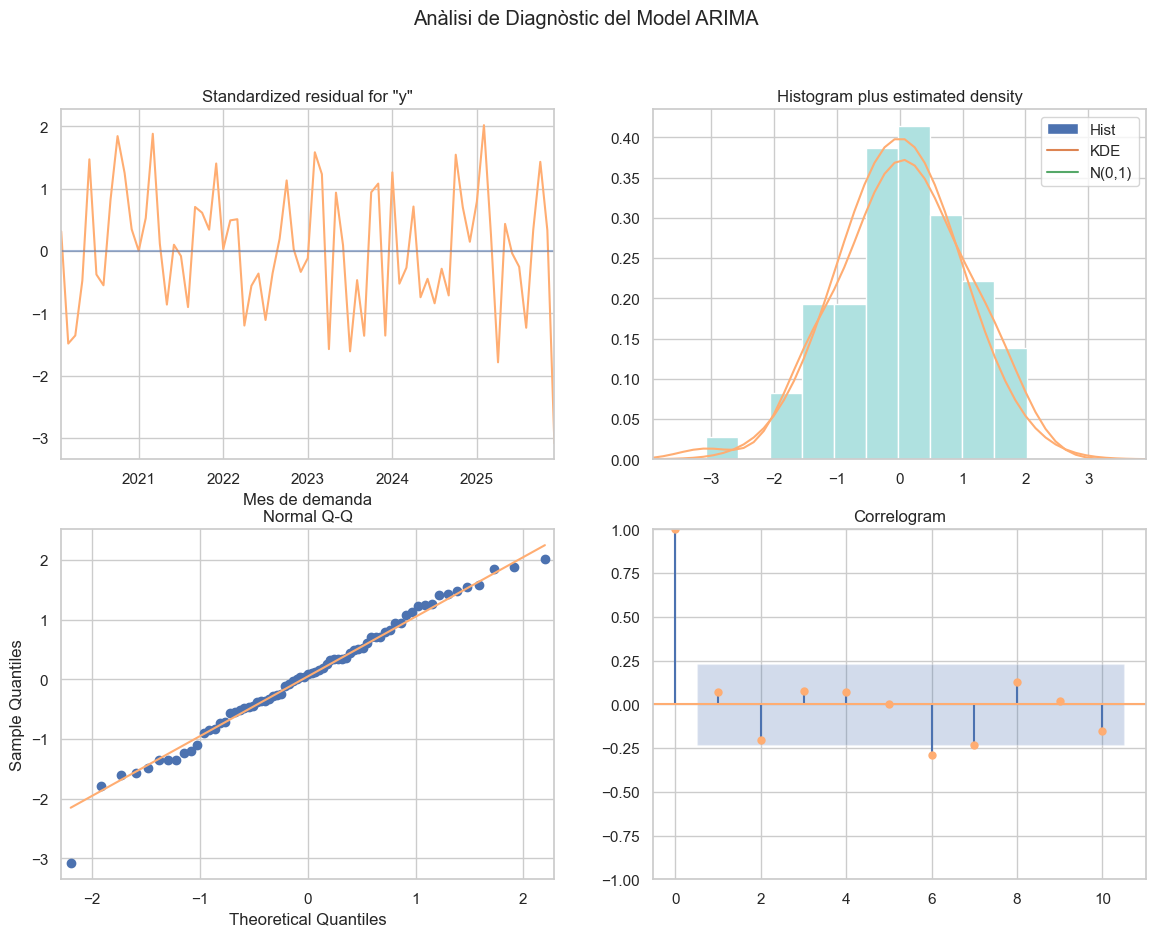

In [16]:
fig = model_fit_ARIMA.plot_diagnostics(figsize=(14, 10))

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("#ffad72")

    for patch in ax.patches:
        patch.set_facecolor("#afe1e0")

plt.suptitle("Anàlisi de Diagnòstic del Model ARIMA")
plt.show()

Com mostren els gràfics, no hi ha un patró en la visualització dels residuals, no hi ha heteroscedasticitat. El gràfic Q-Q s'aproxima a la normalitat, amb certes desviacions als valors extrems. El diagnòstic és acceptable, però no captura tota l'estructura de la sèrie.

Per aquesta raó, es procedeix a elaborar un model ARIMA amb component estacional.

## 2. Creació del model SARIMA 
### 2.1 SARIMA amb agregació mensual

In [19]:
model_SARIMA = SARIMAX(ts_demanda_cdiap,
    order=(1,1,1),
    seasonal_order=(0,1,1,12),  # estacionalitat anual
    enforce_stationarity=False, # probablement conjunt de dades no estacionari
    enforce_invertibility=False
)
model_fit_SARIMA = model_SARIMA.fit()

model_fit_SARIMA.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56130D+00    |proj g|=  4.81567D-02

At iterate    5    f=  2.54966D+00    |proj g|=  2.08439D-02

At iterate   10    f=  2.52197D+00    |proj g|=  6.80393D-03

At iterate   15    f=  2.52112D+00    |proj g|=  4.01637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   5.761D-06   2.521D+00
  F =   2.5211161149762775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -181.520
Date:                            Sun, 21 Dec 2025   AIC                            371.041
Time:                                    20:44:12   BIC                            378.267
Sample:                                01-01-2020   HQIC                           373.735
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0121      0.316      0.038      0.969      -0.608       0.632
ma.L1         -0.6865      0.208     -3.296      0.001      -1.095      -0.278
ma.S.L12      -0.7689      0.372     -2.066      0.039      -1.498      -0.039
sigma2       169.2097     30.778      5.498      0.000     108.885     229.534
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.19
Prob(Q):                              0.94   Prob(JB):                         0.07
Heteroskedasticity (H):               1.94   Skew:                            -0.55
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La incorporació de la dimensió estacional millora l'ajust del model.

En aquest model, el terme autoregressiu no és significatiu, en canvi, el de mitjana mòbil estacional (ma.S.L12) la mitjana mòbil d'ordre 1 (ma.L1) són significatius. Demostrant així que la sèrie té una forta influència de patrons estacionals, visible també per al valor menor d'AIC (de 582 a 371).

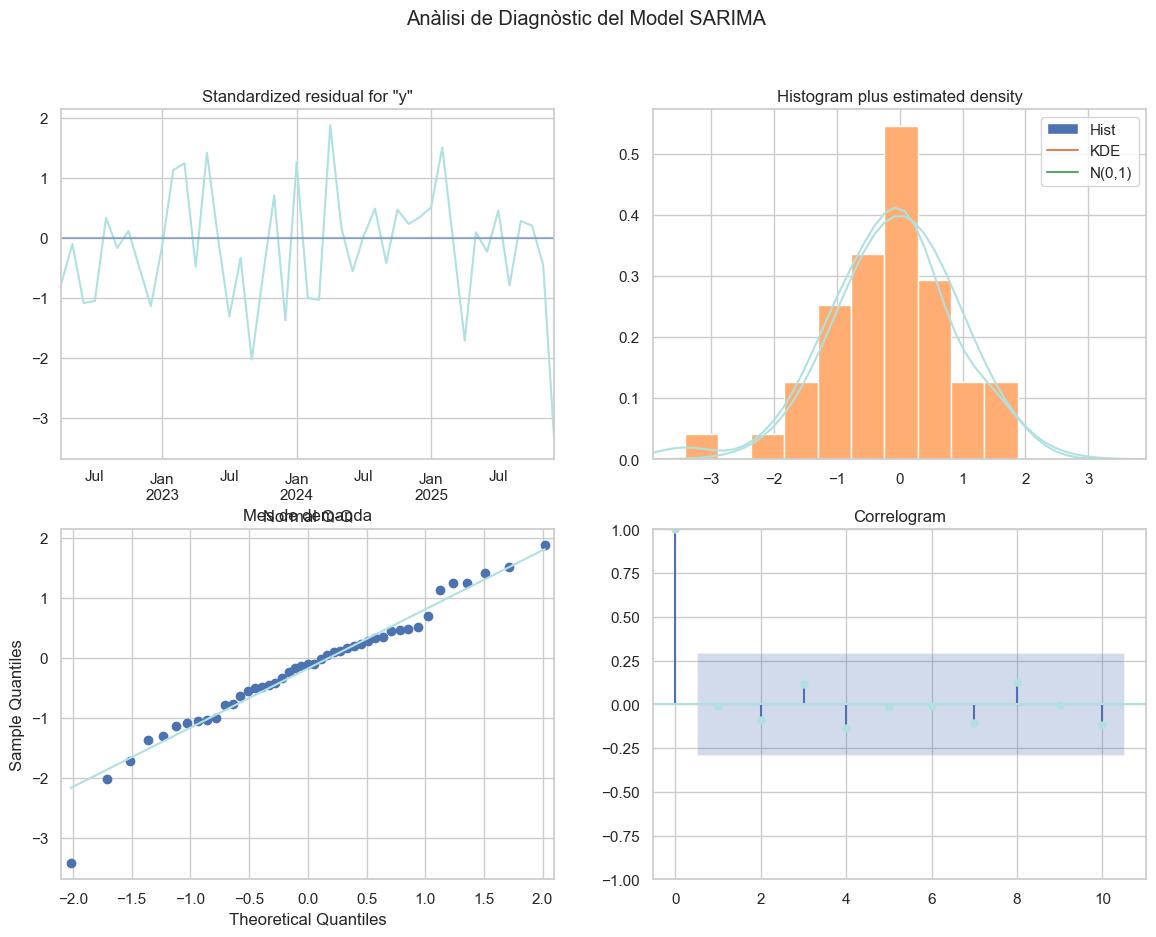

In [21]:
fig = model_fit_SARIMA.plot_diagnostics(figsize=(14, 10))

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("#afe1e0")

    for patch in ax.patches:
        patch.set_facecolor("#ffad72")

plt.suptitle("Anàlisi de Diagnòstic del Model SARIMA")
plt.show()

En la primera gràfica s'observa un valor atípic pels residus estandarditzats. A l'histograma s'observa una lleugera desviació de la normalitat, amb curtosi elevada, la distribució dels errors s'allunya de la normal. Al diagrama Q-Q observem valors atípics als extrems.
Així i tot, el correlograma dels residus no mostra autocorrelacions importants, i el model captura l'estructura temporal amb l'estacionalitat, cap s'excedeix dels límits.

Es procedeix a aplicar el model sobre una predicció a un any vista:

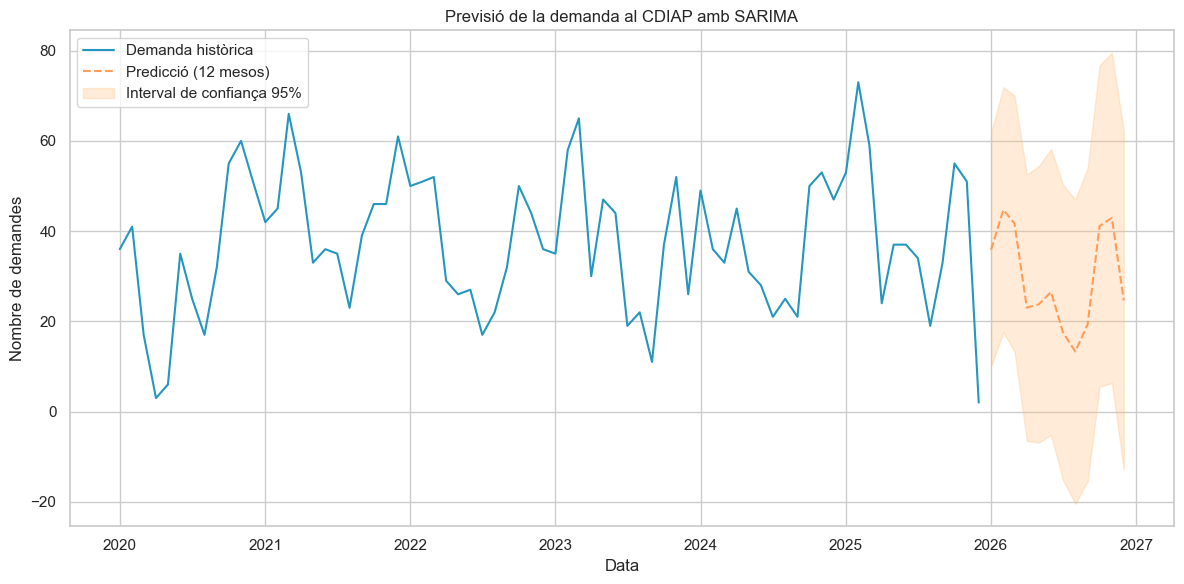

In [24]:
forecast_steps = 12 # Predicció a 12 mesos / 1 any vista
forecast = model_fit_SARIMA.get_forecast(steps=forecast_steps)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Creem un índex temporal pel 2026
last_date = ts_demanda_cdiap.index[-1]
forecast_index = pd.date_range(
    start= last_date + pd.DateOffset(months=1),
    periods=forecast_steps,
    freq="MS"  # 'MS' = Month Start (inici de mes)
)

forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

plt.figure(figsize=(12, 6))

plt.plot(ts_demanda_cdiap, label="Demanda històrica", color="#2596be")
plt.plot(forecast_mean, label="Predicció (12 mesos)", color="#ff9d57", linestyle="--")

# Intervals de confiança
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="#ffbf7b",
    alpha=0.3,
    label="Interval de confiança 95%"
)

plt.title("Previsió de la demanda al CDIAP amb SARIMA")
plt.xlabel("Data")
plt.ylabel("Nombre de demandes")
plt.legend()

plt.tight_layout()
plt.show()

En conjunt, el model SARIMA ofereix un millor ajust que el model base ARIMA.
Tot i la millora, l'interval de confiança és molt ampli.

Probablement es dona per una limitació estructural; l'agregació mensual ens deixa amb només 72 observacions, una mostra massa petita per una sèrie temporal amb tanta variabilitat.

Per aquesta raó, el següent pas serà elaborar un model amb una granularitat menor.

### 2.2 SARIMA amb agregació setmanal

L'últim model estadístic explorat és el SARIMA per agregació setmanal, que ens permet treballar amb un conjunt de dades major (N=310) per així poder captar millor la variabilitat estacional.

In [28]:
ts_demanda_setmanal_cdiap = (
    data_cdiap
    .set_index("Data de demanda")  # Posem la data com a índex
    .resample("W-MON")             # Remostrejem per setmana
    .size()                        
    .fillna(0)                     # IMPORTANT: Hi ha setmanes buides, definim amb 0
)

model_SARIMA_setmanal = SARIMAX(
    ts_demanda_setmanal_cdiap,
    order=(1, 1, 1),              
    seasonal_order=(0, 1, 1, 52), # L'estacionalitat s'adapta a 52 setmanes de l'any
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit_setmanal = model_SARIMA_setmanal.fit()

model_fit_setmanal.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95701D+00    |proj g|=  6.92521D-02

At iterate    5    f=  1.91769D+00    |proj g|=  1.27336D-01

At iterate   10    f=  1.91458D+00    |proj g|=  3.36506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   9.010D-05   1.915D+00
  F =   1.9145790480257134     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  310
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -593.520
Date:                            Sun, 21 Dec 2025   AIC                           1195.039
Time:                                    20:44:30   BIC                           1208.292
Sample:                                01-13-2020   HQIC                          1200.401
                                     - 12-15-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1096      0.090      1.220      0.222      -0.066       0.286
ma.L1         -0.9065      0.041    -22.199      0.000      -0.986      -0.826
ma.S.L52      -0.8586      0.226     -3.807      0.000      -1.301      -0.417
sigma2        17.3810      3.664      4.744      0.000      10.200      24.562
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.93   Prob(JB):                         0.65
Heteroskedasticity (H):               1.12   Skew:                             0.15
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Els resultats confirmen la hipòtesi de l'estacionalitat, el component autoregressiu (ar.L1) perd rellevància, però els termes de mitjana mòbil i estacional (ma.L1 i Ma.S.L52) són molt significatius.

Per tant, la demanda d'una setmana s'explica millor pel moment de l'any en què es troba que no per la setmana immediatament anterior.

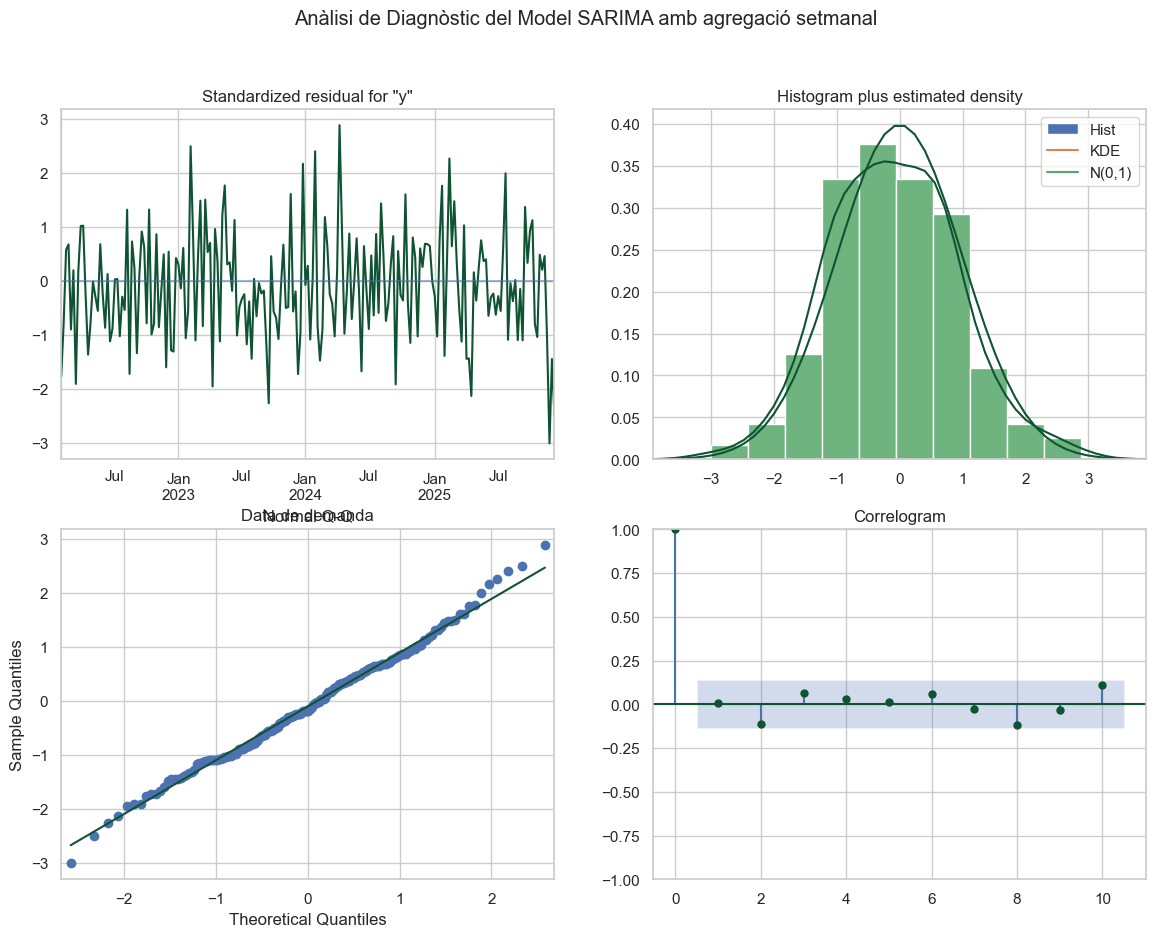

In [30]:
fig = model_fit_setmanal.plot_diagnostics(figsize=(14, 10))

for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("#0e5332")

    for patch in ax.patches:
        patch.set_facecolor("#6fb37f")

plt.suptitle("Anàlisi de Diagnòstic del Model SARIMA amb agregació setmanal")
plt.show()

La variància dels errors es manté costant al llarg del temps. L'histograma confirma que la distribució dels residus és normal. La variància dels errors es manté constant al llarg del temps.

S'observa una millora substancial del model en tots els aspectes.

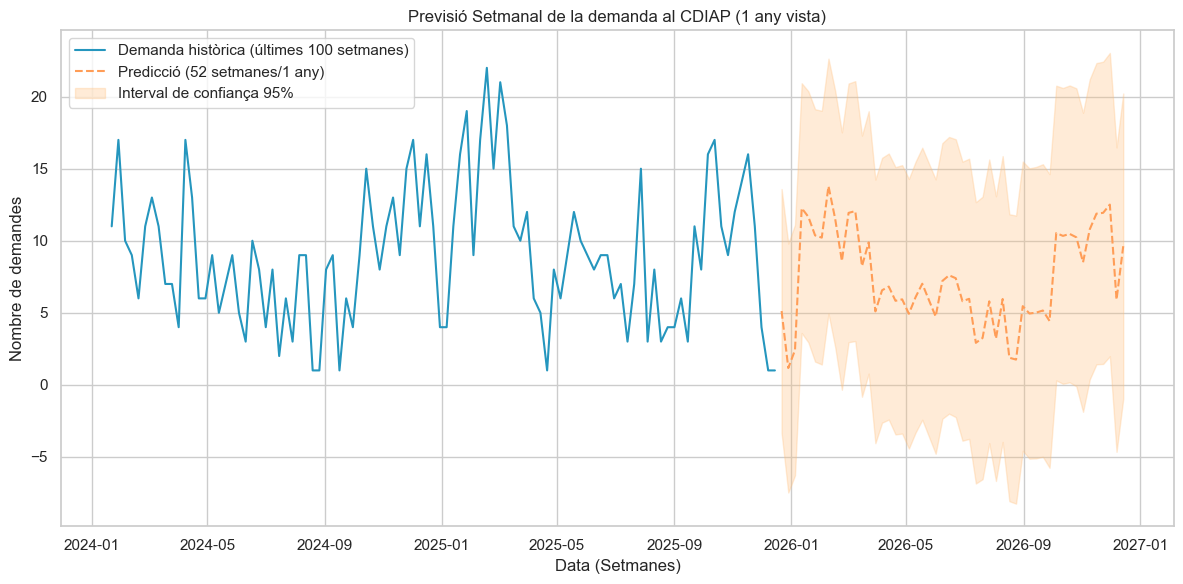

In [32]:
# 1 any de predicció són 52 setmanes
forecast_steps = 52 
forecast = model_fit_setmanal.get_forecast(steps=forecast_steps)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

last_date = ts_demanda_setmanal_cdiap.index[-1]

forecast_index = pd.date_range(
    start=last_date + pd.DateOffset(weeks=1), # Comencem la setmana següent
    periods=forecast_steps,
    freq="W-MON"  # IMPORTANT: Freqüència setmanal
)

forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

plt.figure(figsize=(12, 6))

# Grafiquem les últimes 100 setmanes junt amb la predicció
plt.plot(ts_demanda_setmanal_cdiap.tail(100), label="Demanda històrica (últimes 100 setmanes)", color="#2596be")
plt.plot(forecast_mean, label="Predicció (52 setmanes/1 any)", color="#ff9d57", linestyle="--")

# Intervals de confiança
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="#ffbf7b",
    alpha=0.3,
    label="Interval de confiança 95%"
)

plt.title("Previsió Setmanal de la demanda al CDIAP (1 any vista)")
plt.xlabel("Data (Setmanes)")
plt.ylabel("Nombre de demandes")
plt.legend()

plt.tight_layout()
plt.show()

La predicció d'aquest model millora en quant lacaptació dela variabilitat, capturant caigudes típiques en la demanda (festius a l'hivern, vacances escolars a l'estiu...).
Tot i això, l'interval de confiança continua sent ampli, per tant, es pot deduir que s'ha arribat al límit dels models lineals, la variabilitat restant respon a patrons complexos que no pot captar un model SARIMA.

En la següent secció explorarem models d'aprenentatge profund de Deep Learning, per capturar les no-linealitats i reduir la incertesa i comprovar si hi ha una predicció millorada.